# Capstone Project - Week 2

## A) Description of the Project

This project explores specific restaurants with Turkish or Ottoman cusine and related opportunities in New York City. I assume that an investor wants to open up a Turkish restaurant in NYC. NYC is such a diverse metropolitan city with great potential for a restaurant both by the locals and the tourists. However, because it is a very risky and costly investment, making the right choice is very important, especially based on the data.

For this investor, first thing to do should be getting detailed info on the existing Turkish restaurants. Therefore, this project will focus on exploring the existing Turkish restaurants in NYC.

The audience for this project is mainly dining investors, not just investors of Turkish restaurant though. By using this framework, I believe this project can be helpful to all dining investors in any city (while data allows).

As a side note, sometimes opening a business far from your competitors is a great opportinity; however, it is just the vice versa in some cases meaning opening an exact same business next to a competitor will help you AND your competitor because it creates an area of attraction. Nonetheless, this comes in the later stages of the decision process. I will first focus on the first phase of the decision process which is exploring.

## B) A Description of the Data and How It will be Used 

For this project, I will basically use two sources:

a) The first source comes in handy (I must take things easy for now as I am still learning) and it is the list previously provided by coursera instructor: New York City data which contains list Boroughs, Neighborhoods along with their latitude and longitude.

b) To be able to reach the restaurants and their detailed information I will use foursquare API source.

With the first list, I will be able to categorize things geografically and visually, and with foursquare data I will be able to explore the opportunities and the very fine details of the restaurants. First source will also help me analyze the parts of the city where Turkish restaurants are not present.

## C) Methodology - Exploratory data analysis

In [7]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [131]:
#address = '325 W 57th St, New York, NY'

#geolocator = Nominatim(user_agent="ny_explorer")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude
#print(latitude, longitude)


def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [147]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'ETX4I5Y3QWRPWMWQ134A2MPK1SPIUFPIORDP1FFVZUBTBTSQ' # your Foursquare ID
    CLIENT_SECRET = '2Y10UQGUDECEYNFHV2LVMGRS2CT4LE42Z0KQ3SNMZJZA0L1S' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [143]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'ETX4I5Y3QWRPWMWQ134A2MPK1SPIUFPIORDP1FFVZUBTBTSQ' # your Foursquare ID
    CLIENT_SECRET = '2Y10UQGUDECEYNFHV2LVMGRS2CT4LE42Z0KQ3SNMZJZA0L1S' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [144]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

address = '325 W 57th St, New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

In [145]:
new_york_data=get_new_york_data()

In [141]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [136]:
new_york_data.shape

(306, 4)

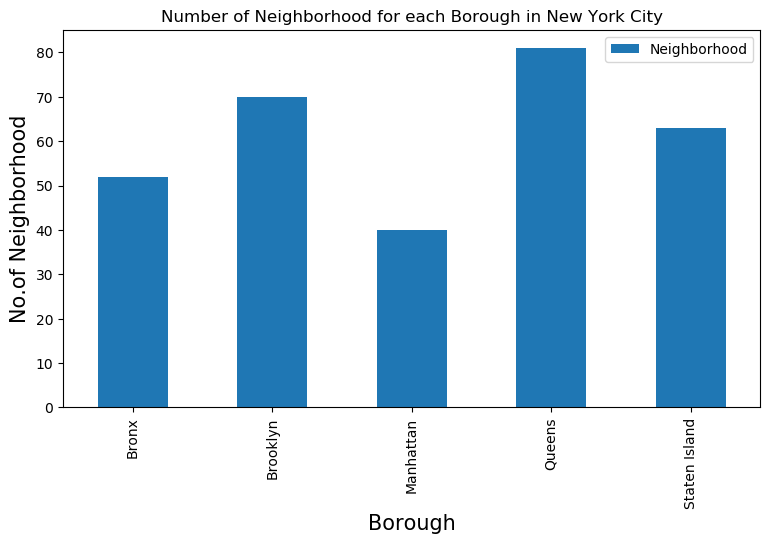

In [137]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [138]:
venues.head(100)

,ID,Name,Category
0,520e520a498e22ba57599f67,Hunts Point Juice Bar,Juice Bar
1,4bbc9e9b8ec3d13a54f71a28,Barretto Point Park,Park
2,4cdee1d6df986ea8d4a4de16,Valencia Bakery,Bakery
3,4bd33314caff9521a542d4f0,Hunts Point Riverside Park,Park
4,573cf8c5498ea0619b6e5a9b,Boogie Down Grind,Coffee Shop
5,4ca3e96c5720b1f78d0936ef,Fratellis Pizza Cafe,Pizza Place
6,4b17aa08f964a520ebc623e3,New Fulton Fish Market,Seafood Restaurant
7,4cd0626c2fd9b60c3b0c81eb,Chase Bank,Bank
8,4c9ca8fc54c8a1cd9e057c4b,Randall Restaurant,Spanish Restaurant
9,4bd98de20115c9b695ab7780,Food Bank for New York City,Food Truck


In [ ]:
# prepare neighborhood list that contains Turkish resturants
import os
column_names=['Borough', 'Neighborhood', 'ID','Name']
turkish_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    turkish_resturants=venues[venues['Category']=='Turkish Restaurant']   
    print('(',count,'/',len(new_york_data),')','Turkish Resturants in '+Neighborhood+', '+Borough+':'+str(len(turkish_resturants)))
    for resturant_detail in turkish_resturants.values.tolist():
        id, name , category=resturant_detail
        turkish_rest_ny = turkish_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


## D) Results and Analysis
### Now that we have got all the Turkish resturants in new york city , we will analyze it

In [95]:
turkish_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant
4,Brooklyn,Sheepshead Bay,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge


In [96]:
turkish_rest_ny.shape

(27, 4)

## 27 Turkish restaurants in NYC

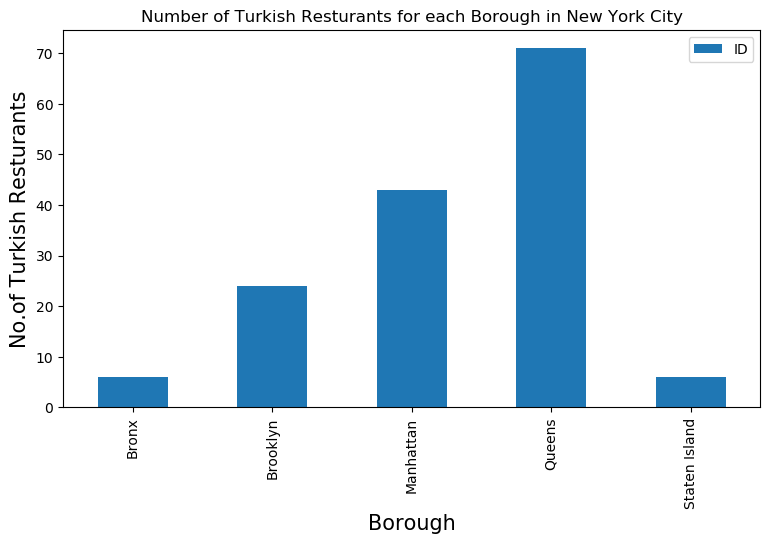

In [97]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Turkish Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Turkish Resturants', fontsize=15)
#giving a bar plot
turkish_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## As expected, Queens has the most Turkish restaurants in NYC, but we should hold onto this idea for now (considering best value investment)

In [98]:
turkish_rest_ny[turkish_rest_ny['Borough']=='Queens'].head()

,Borough,Neighborhood,ID,Name
16,Queens,Sunnyside,4b08b328f964a520021123e3,Turkish Grill
17,Queens,Sunnyside,4a75dd5af964a52076e11fe3,Mangal Kebab
18,Queens,Sunnyside,5be8a67ef870fd002c3a27a2,Sofra Mediterranean Grill
19,Queens,Steinway,5509f620498ed000afdc1bd0,Truva Cafe & Grill
20,Queens,Ravenswood,5cb11a0766f3cd002c371624,Lokanta


### Now we will get the ranking of each resturant for further analysis.

In [ ]:
# prepare neighborhood list that contains Turkish resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
turkish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in turkish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(turkish_rest_ny),')','processed')
    turkish_rest_stats_ny = turkish_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

---------

In [ ]:
turkish_rest_stats_ny.head()

### Now we have data for all resturants. I will save this data to a csv sheet because with a personal FourSquare account, we have limited calls. This way, I will use my own dataset.

In [65]:
turkish_rest_stats_ny.to_csv('turkish_rest_stats_ny.csv', index=False)

### Verification:

In [67]:
turkish_rest_stats_ny_csv=pd.read_csv('turkish_rest_stats_ny.csv')
turkish_rest_stats_ny_csv.shape

(27, 7)

In [169]:
turkish_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay,24,8.2,4
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5,7.1,3
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge,255,8.2,53
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant,93,8.4,37
4,Brooklyn,Sheepshead Bay,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge,113,7.5,19


# Sidenote: I am glad I saved the data in a csv file because when I was trying to fix some things, I reached my foursquare call limit, and I cannot change anything with the original source now. Please ignore above not-run codes, they were run previouly.

In [173]:
turkish_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
Borough         27 non-null object
Neighborhood    27 non-null object
ID              27 non-null object
Name            27 non-null object
Likes           27 non-null int64
Rating          27 non-null float64
Tips            27 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.6+ KB


### I would need to convert values like Likes, Tips from str into float for further analysis:

In [174]:
turkish_rest_stats_ny_csv['Likes']=turkish_rest_stats_ny_csv['Likes'].astype('float64')

In [177]:
turkish_rest_stats_ny['Tips']=turkish_rest_stats_ny['Tips'].astype('int64')

In [159]:
#turkish_rest_stats_ny['Rating']=turkish_rest_stats_ny['Rating'].astype('float64')

In [178]:
turkish_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
Borough         27 non-null object
Neighborhood    27 non-null object
ID              27 non-null object
Name            27 non-null object
Likes           27 non-null float64
Rating          27 non-null float64
Tips            27 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.6+ KB


In [200]:
turkish_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay,24.0,8.2,4
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5.0,7.1,3
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge,255.0,8.2,53
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant,93.0,8.4,37
4,Brooklyn,Sheepshead Bay,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge,113.0,7.5,19


### All looks good good! Let's see the restaurant with the most likes:

In [179]:
turkish_rest_stats_ny_csv.iloc[turkish_rest_stats_ny_csv['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood             Upper East Side
ID              49eb9b35f964a52001671fe3
Name                             Beyoglu
Likes                                416
Rating                               8.2
Tips                                 178
Name: 14, dtype: object

In [180]:
# Resturant with maximum Rating
turkish_rest_stats_ny_csv.iloc[turkish_rest_stats_ny_csv['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              50fc9a88e4b04cfffaebe2cf
Name                             Sip Sak
Likes                                280
Rating                                 9
Tips                                 100
Name: 23, dtype: object

In [181]:
turkish_rest_stats_ny_csv.iloc[turkish_rest_stats_ny_csv['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood             Upper East Side
ID              49eb9b35f964a52001671fe3
Name                             Beyoglu
Likes                                416
Rating                               8.2
Tips                                 178
Name: 14, dtype: object

In [274]:
ny_neighborhood_stats=turkish_rest_stats_ny_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
#ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
#ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
#Borough	Neighborhood	ID	Name	Likes	Rating	Tips

### Top neighborhoods with top average rating of Turkish resturants

In [275]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
14,Turtle Bay,9.0
8,Ocean Parkway,8.9
7,Manhattan Terrace,8.9
9,Ravenswood,8.6
11,Steinway,8.6
15,Upper East Side,8.2
3,Dyker Heights,8.2
1,Bay Ridge,8.2
4,Forest Hills Gardens,8.1
16,Upper West Side,8.0


In [276]:
ny_borough_stats=turkish_rest_stats_ny_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

### The average rating of Turkish Resturants for each Borough

In [277]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.400000
2,Queens,8.077778
0,Brooklyn,8.035714
3,Staten Island,0.000000


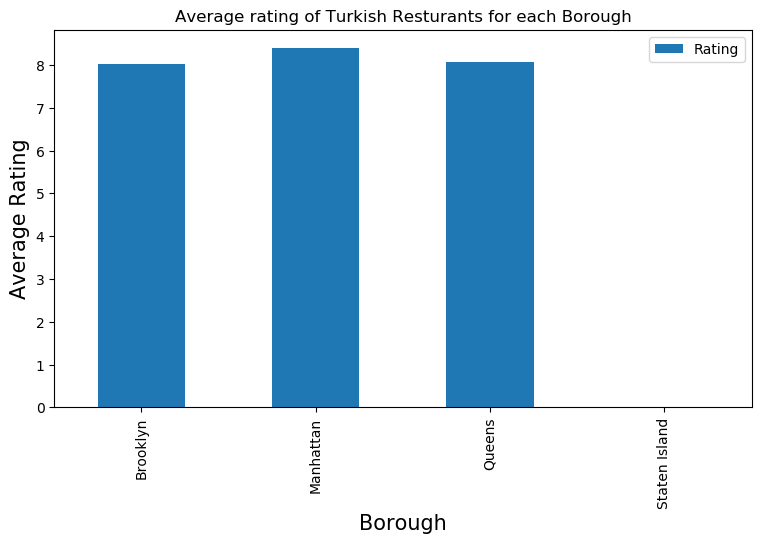

In [278]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Turkish Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
turkish_rest_stats_ny_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### I don't have a big data; however, for the sake of practice, the neighborhoods with average rating greater or equal 8.0 will be visualized on map

In [279]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [280]:
ny_neighborhood_stats

,Neighborhood,Average Rating
1,Bay Ridge,8.2
3,Dyker Heights,8.2
4,Forest Hills Gardens,8.1
7,Manhattan Terrace,8.9
8,Ocean Parkway,8.9
9,Ravenswood,8.6
11,Steinway,8.6
14,Turtle Bay,9.0
15,Upper East Side,8.2
16,Upper West Side,8.0


In [281]:
#ny_neighborhood_stats=pd.merge(turkish_rest_stats_ny_csv,new_york_data, on='Neighborhood')
#turkish_rest_stats_ny_csv
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [282]:
ny_neighborhood_stats=ny_neighborhood_stats[['Neighborhood','Latitude','Longitude','Average Rating']]

In [283]:
ny_neighborhood_stats

,Neighborhood,Latitude,Longitude,Average Rating
0,Bay Ridge,40.625801,-74.030621,8.2
1,Dyker Heights,40.619219,-74.019314,8.2
2,Forest Hills Gardens,40.714611,-73.841022,8.1
3,Manhattan Terrace,40.614433,-73.957438,8.9
4,Ocean Parkway,40.613060,-73.968367,8.9
5,Ravenswood,40.761705,-73.931575,8.6
6,Steinway,40.775923,-73.902290,8.6
7,Turtle Bay,40.752042,-73.967708,9.0
8,Upper East Side,40.775639,-73.960508,8.2
9,Upper West Side,40.787658,-73.977059,8.0


In [284]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [286]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
#for lat, lng, in turkish_rest_stats_ny_csv[['Latitude','Longitude']].values:
#turkish_rest_stats_ny_csv
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [287]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [288]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## E) Discussion

Sometimes opening a business far from your competitors is a great opportunity; however, it is just the vice versa in some cases meaning opening an exact same business next to a competitor will help you AND your competitor because it creates an area of attraction. This comes in the later stages of the decision process, but with this idea in mind, I explored existing Turkish restaurants in NYC. With a quick research, we can see that there are not many Turkish restaurants compared to other ethnic restaurants. There are a total of 27 Turkish restaurants in NYC.

The results suggest that even though Queens has the most Turkish restaurants, the ones in Manhattan area have the most likes and ratings. For example, 'Sip Sak' (or aka Sipsak) is the highest-rated Turkish restaurant in NYC and it is located in Manhattan. This directed me to do quick qualitative research on these restaurants, and I can see that this can be confirmed by the customers' comments.

Turkish restaurants in Queens are more focused on speediness and affordability (for instance, take out lunch orders) while Turkish restaurants in Manhattan are cozy and expensive places where people spend some time and truly enjoy the food.

## F) Conclusion

In conclusion, making a decision based on quantitative and qualitative data is unprecedently important. Investors who trust solely their instincts are more likely to fail (small- or large-scale, I've personally seen many incidents).

In this (imaginary) project, the above-mentioned idea is even more important because most of the Turkish cuisine dining investors would not originally from the States. This suggests that knowing the culture and customs of the host country plays an essential role in the business dynamics. What the investor should know are a) expectations such as delivering a safe and stable quality that will not change even if the staff changes, b) current trends (this report partly provides this), and c) further research based on this report.

## End of Report